## 该Notebook是V12版本的OpenFISH decoding代码，特性如下：  

* RS-FISH现在按照每一轮设置参数
* 也可以使用Spotiflow进行信号点识别
* 接受的输入为zen导出的小图（tile），且需要对应的xml文件；
* 全程都可以在notebook内部完成 
* 使用的包见 D:/openFISH/Decoding/openDecode
* 主要包含图像对齐-图像拼接-信号点识别-图像解码四个部分
* 图像对齐使用SimpleElastix，图像拼接使用m2stitch，信号点识别使用RS-FISH，图像解码使用PoSTCode
* 支持多模态分割与DAPI膨胀

<div class="alert alert-block alert-info">
<b>蓝色cell代表一些提示，请仔细阅读。每个cell中的原生注释也请仔细阅读</b></div>

<div class="alert alert-block alert-success">
<b>绿色cell代表主要步骤的header</b> 
</div>

<div class="alert alert-block alert-warning">
<b>黄色cell代表需要人工检查</b>
</div>

___

<div class="alert alert-block alert-info">
<b>提示：</b>拍图时不要设置通道位移参数， 拍图请仔细调整曝光时间和曝光强度，避免过曝，淬灭或过暗。拍图通道请选择"AF405","AF488","AF546","AF594","Cy5","Cy7"</div>

<div class="alert alert-block alert-info">
<b>提示：</b>请使用 "序列矫正(可选)" --> "景深扩展(方法使用最大投影，起始位置可以根据实际选择)" --> "去模糊(强度 = 0.5，BlurRadius = 3，Sharpness = 0)"处理图像</div>

<div class="alert alert-block alert-info">
<b>提示：</b>请不要使用拼接，上述处理完成后传到图像处理电脑，然后使用Zen导出图像，导出图像方法和参数见下：</div>

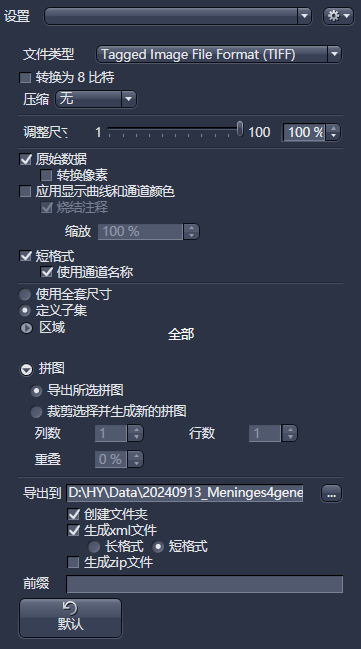

<div class="alert alert-block alert-success">
<b><h2> 1.填写参数（最重要的部分，之后的函数中有一些参数也可以根据需要修改）</b></h2> 
</div>

<div class="alert alert-block alert-info">
<b>提示:</b>使用时建议将该Notebook复制到一个单独的文件夹中，然后设置该文件夹为workpath</div>

<div class="alert alert-block alert-info">
<b>提示:</b>该版本notebook使用了新的CodingBook格式，详见 D:/openFISH/Decoding/CodingBook.csv</div>

In [ ]:
filename = {
    "R2":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R2_depth_deblur",
    "R3":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R3_depth_deblur",
    "R4":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R4_depth_deblur",
    "R5":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R5_depth_deblur",
    "R6":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R6_depth_deblur",
    "R7":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R7_depth_deblur",
    "R8":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R8_depth_deblur",
    "R9":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R9_depth_deblur",
    "R10":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R10_depth_deblur",
    "R11":"I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_R11_depth_deblur",
} 

# CodingBooks，如果方法是10N，具体格式参考D:/openFISH/Decoding/CodingBook_10N.csv
# CodingBooks，如果方法是DDC，具体格式参考D:/openFISH/Decoding/CodingBook_MultiCycle.csv
# 空缺的编码请用FP1，FP2等或者任意不重复字符替代
CodingBook = "I:/WS/20250729_MALDI_Saline/MALDI_CodingBook.CSV"


method_type = "10N" # 10N 或者 MultiCycle
workpath = "./"
output_path = "Result"
objective = "20X" # 20X or 40X
rRNA= "I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_rRNA_depth" # path or None
extra = "I:/WS/20250729_MALDI_Saline/20250727_MALDI_Saline2_8_DIC_depth" # path or None
baysor = False # True or False
BaSiC = True # True or False
phase_cross_correction = False # 不同轮之间位移较大（x或y大于50个像素时，填True）

In [ ]:
import sys
sys.path.append("D:/openFISH/Decoding")

from openDecode.Preprocess import Para, tilePreprocess
from openDecode.TileStitch import multiCycleRegister
from openDecode.ThirdParty import runRSFISHforTiles, runBaysor, runSpotiflow
from openDecode.PointsCalling import filterPoints
from openDecode.Decoding import Decoding
from openDecode.Visualization import *

<div class="alert alert-block alert-success">
<b><h2> 2.图像对齐与拼接</b></h2> 
</div>

<div class="alert alert-block alert-info">
<b>i.</b>初始化参数，新建output文件夹，重构codebook</div>

In [ ]:
para = Para(filename = filename, CodingBook = CodingBook, method_type = method_type, 
                 workpath = workpath,  output_path = output_path, objective = objective, rRNA = rRNA,
                 extra = extra, baysor = baysor, phase_cross_correction = phase_cross_correction, BaSiC = BaSiC)

<div class="alert alert-block alert-info">
<b>ii.</b>原始图像预处理</div>

In [ ]:
tilePreprocess(para)

<div class="alert alert-block alert-info">
<b>iii.</b>小图对齐与拼接</div>

In [ ]:
multiCycleRegister(para)

<div class="alert alert-block alert-success">
<b><h2> 3.信号点识别</b></h2> 
</div>

<div class="alert alert-block alert-info">
<b>i.</b>请设置RS-FISH参数， 可以在工作目录下的Registration/stitched/processed中找到拼接图像，建议先手动测试一下参数</div>

<div class="alert alert-block alert-info">
<b>ii.</b>RS-FISH与细胞分割同时进行</div>

In [ ]:
runSpotiflow(para,
             model_name = "general",
             prob_thresh = None,
             min_distance = 1,
             exclude_border = True,
             subpix = True,
             peak_mode ='fast',
             normalizer = 'auto',
             device = 'cuda')

stardist_roi = False
from openDecode.ThirdParty import runStardist_and_Cellpose
stardist_roi = runStardist_and_Cellpose(para, prob_thresh = 0.5, nms_thresh = 0.4, trained_model = '2D_versatile_fluo', sigma = 2.5)

<div class="alert alert-block alert-info">
<b>ii.</b>将RS-FISH结果转变成PoSTCode输入</div>

In [ ]:
Spots_Dict, image_size = filterPoints(para)

<div class="alert alert-block alert-success">
<b><h2> 4.解码</b></h2> 
</div>

<div class="alert alert-block alert-info">
<b>i.</b>运行PoSTcode</div>

In [ ]:
Final_df = Decoding(Spots_Dict, para)

<div class="alert alert-block alert-info">
<b>ii.</b>绘制基因点图和后验概率图像</div>

In [ ]:
plotGene(Final_df, para, image_size)
plot_probs(Final_df, para)

<div class="alert alert-block alert-info">
<b>iii.</b>输出结果到Xenium Explorer</div>

In [ ]:
if para.baysor == True:
    import os
    Final_df.to_csv(os.path.join(para.output, "gene_location_merged_filtered.csv"))
    runBaysor(para, min_molecules_per_cell = 5, count_matrix_format = "loom", prior_segmentation_confidence = 0.3, scale = 30, scale_std = "50%")
    
plotXenium(Final_df, para, stardist_roi)